In [133]:
# Установка библиотек
!pip install gymnasium swig stable-baselines3 torch numpy matplotlib imageio "gymnasium[box2d]" imageio-ffmpeg tensorboard


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [182]:
# Параметры эксперимента
ENV_NAME = 'LunarLander-v3'
SEED = 42
TOTAL_TIMESTEPS = 300000
EVAL_EPISODES = 20  # Количество эпизодов для финальной оценки

In [159]:
# Импорты
import gymnasium as gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import imageio
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')

# Фиксируем seed для воспроизводимости
np.random.seed(SEED)
import torch

torch.manual_seed(SEED)
import random

random.seed(SEED)

print("Библиотеки загружены успешно!")

Библиотеки загружены успешно!


In [160]:
# Воспроизводимость: pip freeze для фиксации версий
!pip freeze > requirements_freeze.txt
print("Версии пакетов сохранены в requirements_freeze.txt")

Версии пакетов сохранены в requirements_freeze.txt


In [161]:
# Создание директорий для сохранения моделей и результатов
os.makedirs('models', exist_ok=True)
os.makedirs('data', exist_ok=True)
os.makedirs('videos', exist_ok=True)
print("Директории созданы")

Директории созданы


In [163]:
from IPython.display import Image

# Reward Shaping: Wrapper для добавления штрафа за использование топлива
class FuelPenaltyWrapper(gym.Wrapper):
    """
    Обёртка для добавления штрафа за использование топлива в LunarLander.
    Штраф применяется к награде на каждом шаге.
    """

    def __init__(self, env, fuel_penalty_weight=0.01):
        super().__init__(env)
        self.fuel_penalty_weight = fuel_penalty_weight

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        # В LunarLander-v3 награда уже включает штрафы за использование двигателей
        # Но мы можем добавить дополнительный штраф за активное использование топлива
        # Действия 1, 2, 3 - это использование двигателей (main, left, right)
        if action in [1, 2, 3]:
            fuel_penalty = -self.fuel_penalty_weight
            reward += fuel_penalty

        return obs, reward, terminated, truncated, info


def make_env(env_name, seed=SEED, fuel_penalty=False, fuel_penalty_weight=0.01):
    """Создание окружения с возможностью добавления штрафа за топливо"""

    def _init():
        env = gym.make(env_name, render_mode=None)
        env = Monitor(env)
        if fuel_penalty:
            env = FuelPenaltyWrapper(env, fuel_penalty_weight=fuel_penalty_weight)
        env.reset(seed=seed)
        return env

    return _init


print("Reward shaping wrapper создан")


# Класс-обертка для агентов с хранением путей и методами для работы с логами
class AgentWrapper:
    """
    Обертка для агента, которая хранит пути к логам и модели,
    и предоставляет методы для чтения данных обучения и записи видео.
    """

    def __init__(self, model, algorithm, model_save_path=None,
                 best_model_save_path=None, eval_log_path=None, fuel_penalty=False):
        """
        Параметры:
        ----------
        model : обученная модель (PPO или A2C)
        algorithm : str, тип алгоритма ('PPO' или 'A2C')
        model_save_path : str, путь к сохраненной модели
        best_model_save_path : str, путь к лучшей модели
        eval_log_path : str, путь к логам оценки
        fuel_penalty : bool, использовался ли reward shaping
        """
        self.model = model
        self.algorithm = algorithm
        self.model_save_path = model_save_path
        self.best_model_save_path = best_model_save_path
        self.eval_log_path = eval_log_path
        self.fuel_penalty = fuel_penalty
        self.evaluate_results = {}

        # Формируем имя агента для отображения
        self.name = f"{algorithm}"
        if fuel_penalty:
            self.name += " + Reward Shaping"
        else:
            self.name += " (базовая)"

    def load_eval_data(self):
        """
        Загрузка данных оценки из логов
        
        Возвращает:
        ----------
        dict или None: словарь с данными оценки или None, если файл не найден
        """
        if self.eval_log_path is None:
            return None

        eval_file = os.path.join(self.eval_log_path, 'evaluations.npz')
        if os.path.exists(eval_file):
            data = np.load(eval_file)
            return {
                'timesteps': data['timesteps'],
                'results': data['results'],
                'ep_lengths': data.get('ep_lengths', None)
            }
        return None

    def load_training_data(self, log_dir=None):
        """
        Загрузка данных обучения из Monitor
        
        Параметры:
        ----------
        log_dir : str, путь к директории с логами (если None, используется eval_log_path)
        
        Возвращает:
        ----------
        DataFrame или None: данные обучения или None, если файлы не найдены
        """
        if log_dir is None:
            log_dir = self.eval_log_path if self.eval_log_path else './data/'

        if not os.path.exists(log_dir):
            return None

        files = [f for f in os.listdir(log_dir) if f.startswith('monitor')]
        if not files:
            return None

        data = []
        for file in files:
            try:
                df = pd.read_csv(os.path.join(log_dir, file), skiprows=1)
                data.append(df)
            except:
                continue

        if data:
            combined = pd.concat(data, ignore_index=True)
            return combined
        return None

    def predict(self, *args, **kwargs):
        """Прокси-метод для предсказания модели"""
        return self.model.predict(*args, **kwargs)

    def save(self, path=None):
        """Сохранение модели"""
        save_path = path or self.model_save_path
        if save_path:
            self.model.save(save_path)
        else:
            raise ValueError("Не указан путь для сохранения модели")

    def __getattr__(self, name):
        """Прокси для доступа к атрибутам модели"""
        return getattr(self.model, name)

    def add_graphic(self, color):
        eval_data_ppo = self.load_eval_data()
        timesteps_ppo = eval_data_ppo['timesteps']
        mean_rewards_ppo = eval_data_ppo['results'].mean(axis=1)
        std_rewards_ppo = eval_data_ppo['results'].std(axis=1)
        plt.plot(timesteps_ppo, mean_rewards_ppo, label=self.name, linewidth=2, color=color)
        plt.fill_between(timesteps_ppo, mean_rewards_ppo - std_rewards_ppo,
                         mean_rewards_ppo + std_rewards_ppo, alpha=0.3, color=color)

        from IPython.display import Image


    # Функция для создания видео агента (один полный эпизод)
    def record_video(self, max_steps=1000):
        """Запись видео работы агента - один полный эпизод от начала до завершения"""
        env = gym.make(ENV_NAME, render_mode='rgb_array')
        if self.fuel_penalty:
            env = FuelPenaltyWrapper(env, fuel_penalty_weight=0.01)

        images = []
        obs, info = env.reset(seed=SEED)
        img = env.render()
        images.append(img)

        step_count = 0
        while step_count < max_steps:
            action, _ = self.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            img = env.render()
            images.append(img)
            step_count += 1

            # Завершаем запись, когда эпизод закончился
            if terminated or truncated:
                break

        env.close()
        return images


    def save_video(self):
        print(f'Создание видео для агента {self.name}')
        images = self.record_video()
        imageio.mimsave(f'./videos/{self.name}.gif', images, fps=30)
        print(f"Видео A2C с reward shaping сохранено в ./videos/{self.name}.gif")
        display(Image(f'./videos/{self.name}.gif'))

    def evaluate(self):
        """Оценка агента на n эпизодах"""
        env = gym.make(ENV_NAME, render_mode=None)
        if self.fuel_penalty:
            env = FuelPenaltyWrapper(env, fuel_penalty_weight=0.01)

        episode_rewards = []
        episode_lengths = []

        for episode in range(EVAL_EPISODES):
            obs, info = env.reset(seed=SEED + episode)
            total_reward = 0
            steps = 0

            while True:
                action, _ = self.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = env.step(action)
                total_reward += reward
                steps += 1

                if terminated or truncated:
                    break

            episode_rewards.append(total_reward)
            episode_lengths.append(steps)

        env.close()

        results = {
            'mean_reward': np.mean(episode_rewards),
            'std_reward': np.std(episode_rewards),
            'min_reward': np.min(episode_rewards),
            'max_reward': np.max(episode_rewards),
            'mean_length': np.mean(episode_lengths),
            'rewards': episode_rewards,
            'lengths': episode_lengths
        }
        self.evaluate_results = results
        print(f"Оценка :{self.name}")
        print(f"Средняя награда: {results['mean_reward']:.2f} ± {results['std_reward']:.2f}")
        print(f"Диапазон: [{results['min_reward']:.2f}, {results['max_reward']:.2f}]")
        print(f"Средняя длина эпизода: {results['mean_length']:.1f}")

print("Класс AgentWrapper создан")

Reward shaping wrapper создан
Класс AgentWrapper создан


In [208]:
# Функция для обучения агента с мониторингом
def train_agent(
        algorithm='PPO',  # 'PPO' или 'A2C'
        env_name=ENV_NAME,
        seed=SEED,
        total_timesteps=TOTAL_TIMESTEPS,
        fuel_penalty=False,
        fuel_penalty_weight=0.01,
        model_save_path=None,
        best_model_save_path=None,
        eval_log_path=None,
        eval_freq=10000,
        verbose=1,
        **algorithm_params
):
    """
    Обучение агента с мониторингом и сохранением данных

    Параметры:
    ----------
    algorithm : str
        Тип алгоритма: 'PPO' или 'A2C'
    env_name : str
        Название окружения
    seed : int
        Seed для воспроизводимости
    total_timesteps : int
        Общее количество шагов обучения
    fuel_penalty : bool
        Использовать ли штраф за топливо
    fuel_penalty_weight : float
        Вес штрафа за топливо
    model_save_path : str
        Путь для сохранения финальной модели
    best_model_save_path : str
        Путь для сохранения лучшей модели
    eval_log_path : str
        Путь для сохранения логов оценки
    eval_freq : int
        Частота оценки (в шагах)
    verbose : int
        Уровень детализации вывода
    **algorithm_params : dict
        Дополнительные параметры алгоритма (learning_rate, n_steps, etc.)

    Возвращает:
    ----------
    model : обученная модель
    """
    print("=" * 60)
    print(f"Обучение {algorithm} агента", end="")
    if fuel_penalty:
        print(" с reward shaping (штраф за топливо)")
    else:
        print(" (базовая версия)")
    print("=" * 60)

    # Создание окружений
    env = DummyVecEnv([make_env(env_name, seed=seed, fuel_penalty=fuel_penalty,
                                fuel_penalty_weight=fuel_penalty_weight)])
    eval_env = DummyVecEnv([make_env(env_name, seed=seed + 1, fuel_penalty=fuel_penalty,
                                     fuel_penalty_weight=fuel_penalty_weight)])

    # Параметры по умолчанию для алгоритмов
    if algorithm == 'PPO':
        default_params = {
            'learning_rate': 3e-4,
            'n_steps': 2048,
            'batch_size': 64,
            'n_epochs': 10,
            'gamma': 0.99,
            'gae_lambda': 0.95,
            'clip_range': 0.2,
            'ent_coef': 0.01,
            'vf_coef': 0.5,
            'max_grad_norm': 0.5,
        }
        default_params.update(algorithm_params)
        model = PPO('MlpPolicy', env, verbose=verbose, seed=seed, **default_params)
    elif algorithm == 'A2C':
        default_params = {
            'learning_rate': 7e-4,
            'n_steps': 5,
            'gamma': 0.99,
            'gae_lambda': 0.9,
            'ent_coef': 0.01,
            'vf_coef': 0.5,
            'max_grad_norm': 0.5,
        }
        default_params.update(algorithm_params)
        model = A2C('MlpPolicy', env, verbose=verbose, seed=seed, **default_params)
    else:
        raise ValueError(f"Неизвестный алгоритм: {algorithm}. Используйте 'PPO' или 'A2C'")

    # Callback для оценки во время обучения
    eval_callback = None
    if eval_log_path is not None or best_model_save_path is not None:
        eval_callback = EvalCallback(
            eval_env,
            best_model_save_path=best_model_save_path,
            log_path=eval_log_path,
            eval_freq=eval_freq,
            deterministic=True,
            render=False
        )

    # Обучение
    model.learn(
        total_timesteps=total_timesteps,
        callback=eval_callback,
        progress_bar=False
    )

    # Сохранение модели
    if model_save_path is not None:
        model.save(model_save_path)
        print(f"{algorithm} модель обучена и сохранена в {model_save_path}!")
    else:
        print(f"{algorithm} модель обучена!")

    # Создание обертки для агента
    agent_wrapper = AgentWrapper(
        model=model,
        algorithm=algorithm,
        model_save_path=model_save_path,
        best_model_save_path=best_model_save_path,
        eval_log_path=eval_log_path,
        fuel_penalty=fuel_penalty
    )

    return agent_wrapper


print("Функция train_agent создана")

Функция train_agent создана


In [183]:
# Обучение PPO агента (без reward shaping)
agent_ppo = train_agent(
    algorithm='PPO',
    env_name=ENV_NAME,
    seed=SEED,
    total_timesteps=TOTAL_TIMESTEPS,
    fuel_penalty=False,
    model_save_path='./models/ppo_final',
    best_model_save_path='./models/ppo_best/',
    eval_log_path='./data/ppo_eval/',
    eval_freq=10000)

Обучение PPO агента (базовая версия)
Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 86.7     |
|    ep_rew_mean     | -165     |
| time/              |          |
|    fps             | 4299     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 87.5         |
|    ep_rew_mean          | -163         |
| time/                   |              |
|    fps                  | 3419         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0069905687 |
|    clip_fraction        | 0.00557      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|   

In [209]:
# Обучение A2C агента (без reward shaping)
agent_a2c = train_agent(
    algorithm='A2C',
    env_name=ENV_NAME,
    seed=SEED,
    total_timesteps=TOTAL_TIMESTEPS,
    fuel_penalty=False,
    model_save_path='./models/a2c_final',
    best_model_save_path='./models/a2c_best/',
    eval_log_path='./data/a2c_eval/',
    eval_freq=10000
)

Обучение A2C агента (базовая версия)
Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 152      |
|    ep_rew_mean        | -321     |
| time/                 |          |
|    fps                | 2184     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.13    |
|    explained_variance | -0.0139  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -4.5     |
|    value_loss         | 52       |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 131      |
|    ep_rew_mean        | -358     |
| time/                 |          |
|    fps                | 2335     |
|    iterations         | 200      |
|    time_elapsed       | 0        |
|    total_timesteps 

In [197]:
# Обучение PPO агента с reward shaping (штраф за топливо)
agent_ppo_rs = train_agent(
    algorithm='PPO',
    env_name=ENV_NAME,
    seed=SEED,
    total_timesteps=TOTAL_TIMESTEPS,
    fuel_penalty=True,
    fuel_penalty_weight=0.01,
    model_save_path='./models/ppo_rs_final',
    best_model_save_path='./models/ppo_rs_best/',
    eval_log_path='./data/ppo_rs_eval/',
    eval_freq=10000
)

Обучение PPO агента с reward shaping (штраф за топливо)
Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 86.7     |
|    ep_rew_mean     | -165     |
| time/              |          |
|    fps             | 5186     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 90          |
|    ep_rew_mean          | -161        |
| time/                   |             |
|    fps                  | 3680        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.006955773 |
|    clip_fraction        | 0.00552     |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |

In [210]:
# Обучение A2C агента с reward shaping (штраф за топливо)
agent_a2c_rs = train_agent(
    algorithm='A2C',
    env_name=ENV_NAME,
    seed=SEED,
    total_timesteps=TOTAL_TIMESTEPS,
    fuel_penalty=True,
    fuel_penalty_weight=0.01,
    model_save_path='./models/a2c_rs_final',
    best_model_save_path='./models/a2c_rs_best/',
    eval_log_path='./data/a2c_rs_eval/',
    eval_freq=10000
)

Обучение A2C агента с reward shaping (штраф за топливо)
Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 167      |
|    ep_rew_mean        | -197     |
| time/                 |          |
|    fps                | 2475     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.18    |
|    explained_variance | 0.00192  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -25.9    |
|    value_loss         | 765      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 140      |
|    ep_rew_mean        | -498     |
| time/                 |          |
|    fps                | 2177     |
|    iterations         | 200      |
|    time_elapsed       | 0        |
| 

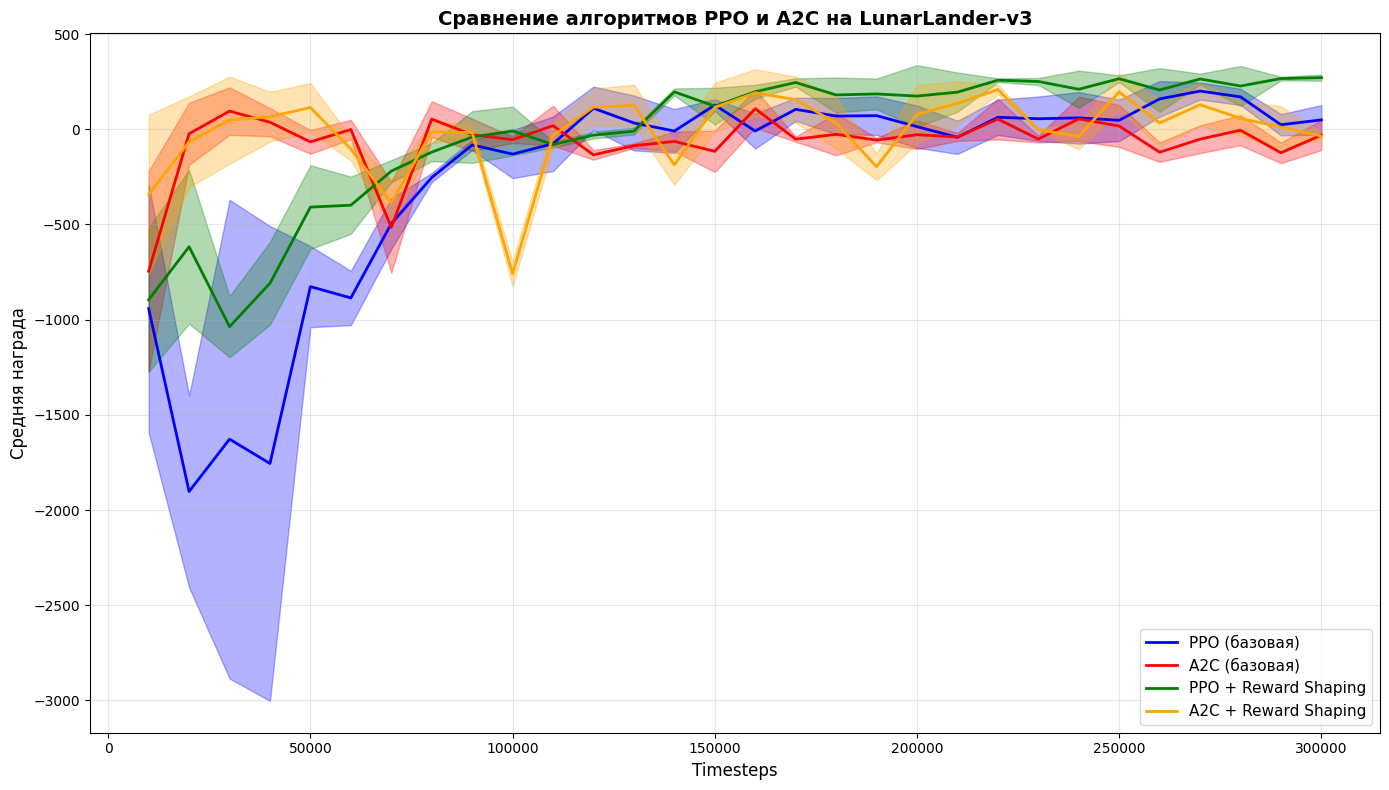

График сохранён в ./data/comparison_timesteps.png


In [211]:
# График сравнения алгоритмов: средняя награда vs timestep
plt.figure(figsize=(14, 8))

agent_ppo.add_graphic('blue')
agent_a2c.add_graphic('red')
agent_ppo_rs.add_graphic('green')
agent_a2c_rs.add_graphic('orange')

plt.xlabel('Timesteps', fontsize=12)
plt.ylabel('Средняя награда', fontsize=12)
plt.title('Сравнение алгоритмов PPO и A2C на LunarLander-v3', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./data/comparison_timesteps.png', dpi=300, bbox_inches='tight')
plt.show()

print("График сохранён в ./data/comparison_timesteps.png")

Создание видео для агента PPO (базовая)
Видео A2C с reward shaping сохранено в ./videos/PPO (базовая).gif


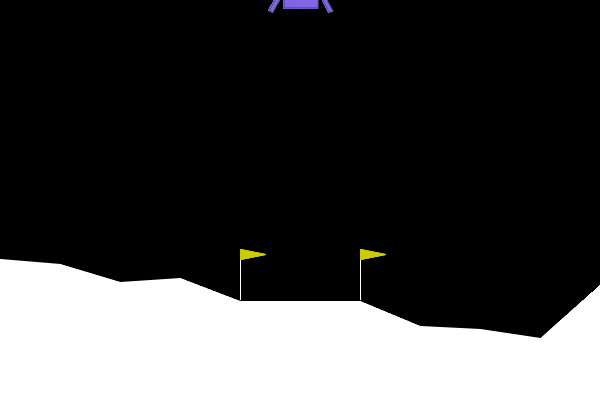

In [212]:
# Создание видео для PPO агента (базовая версия) - один полный эпизод
agent_ppo.save_video()


Создание видео для агента A2C (базовая)
Видео A2C с reward shaping сохранено в ./videos/A2C (базовая).gif


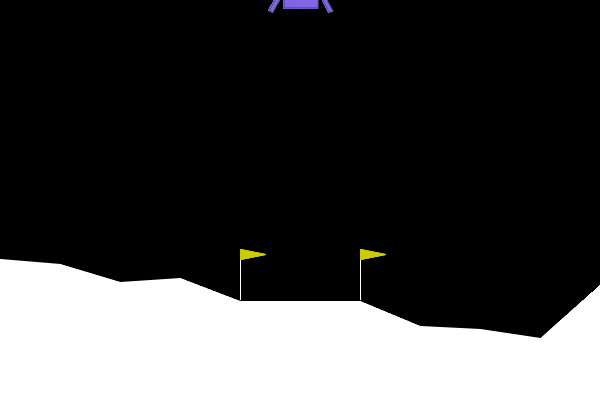

In [213]:
agent_a2c.save_video()

Создание видео для агента PPO + Reward Shaping
Видео A2C с reward shaping сохранено в ./videos/PPO + Reward Shaping.gif


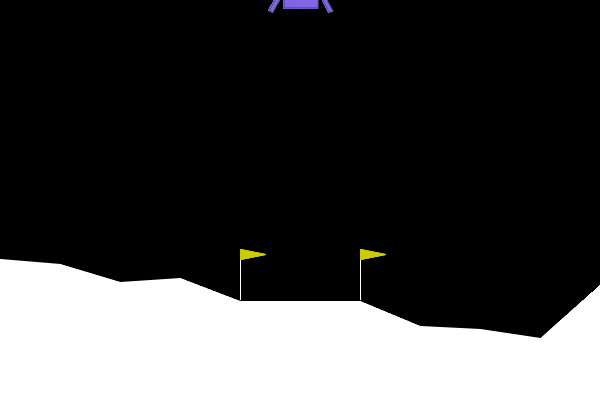

In [214]:
agent_ppo_rs.save_video()

Создание видео для агента A2C + Reward Shaping
Видео A2C с reward shaping сохранено в ./videos/A2C + Reward Shaping.gif


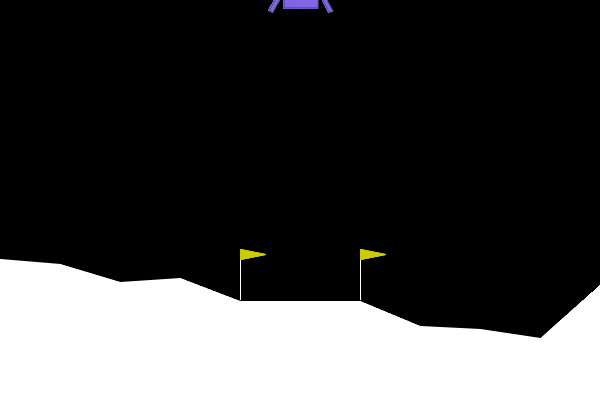

In [215]:
agent_a2c_rs.save_video()

In [216]:
# Количественная оценка итоговых агентов (средняя награда по 10-20 эпизодам)
print("=" * 60)
print("Количественная оценка итоговых агентов")
print("=" * 60)

# Оценка всех агентов
agent_ppo.evaluate()
print("=" * 60)
agent_a2c.evaluate()
print("=" * 60)
agent_ppo_rs.evaluate()
print("=" * 60)
agent_a2c_rs.evaluate()

Количественная оценка итоговых агентов
Оценка :PPO (базовая)
Средняя награда: 73.56 ± 95.72
Диапазон: [-48.05, 238.07]
Средняя длина эпизода: 775.0
Оценка :A2C (базовая)
Средняя награда: -0.96 ± 116.30
Диапазон: [-123.52, 215.94]
Средняя длина эпизода: 586.5
Оценка :PPO + Reward Shaping
Средняя награда: 255.18 ± 28.75
Диапазон: [168.62, 300.42]
Средняя длина эпизода: 305.7
Оценка :A2C + Reward Shaping
Средняя награда: -8.35 ± 77.12
Диапазон: [-77.10, 231.60]
Средняя длина эпизода: 205.2


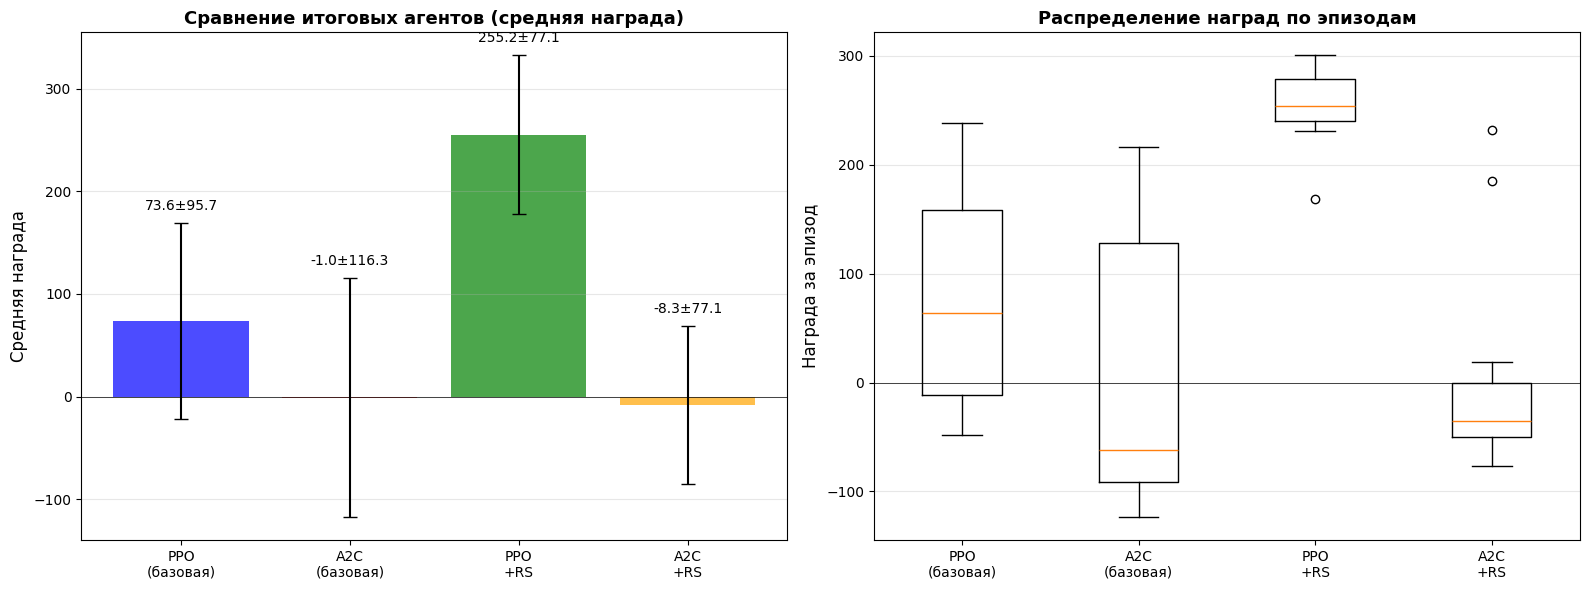

График финальной оценки сохранён в ./data/final_evaluation.png


In [217]:
# Визуализация результатов оценки
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: Сравнение средних наград
agents = ['PPO\n(базовая)', 'A2C\n(базовая)', 'PPO\n+RS', 'A2C\n+RS']
means = [agent_ppo.evaluate_results['mean_reward'], agent_a2c.evaluate_results['mean_reward'],
         agent_ppo_rs.evaluate_results['mean_reward'], agent_a2c_rs.evaluate_results['mean_reward']]
stds = [agent_ppo.evaluate_results['std_reward'], agent_a2c.evaluate_results['std_reward'],
        agent_a2c_rs.evaluate_results['std_reward'], agent_a2c_rs.evaluate_results['std_reward']]

bars = axes[0].bar(agents, means, yerr=stds, capsize=5, alpha=0.7,
                   color=['blue', 'red', 'green', 'orange'])
axes[0].set_ylabel('Средняя награда', fontsize=12)
axes[0].set_title('Сравнение итоговых агентов (средняя награда)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Добавление значений на столбцы
for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2., height + std + 10,
                 f'{mean:.1f}±{std:.1f}',
                 ha='center', va='bottom', fontsize=10)

# График 2: Распределение наград по эпизодам
axes[1].boxplot([agent_ppo.evaluate_results['rewards'], agent_a2c.evaluate_results['rewards'],
                 agent_ppo_rs.evaluate_results['rewards'], agent_a2c_rs.evaluate_results['rewards']],
                labels=agents)
axes[1].set_ylabel('Награда за эпизод', fontsize=12)
axes[1].set_title('Распределение наград по эпизодам', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('./data/final_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("График финальной оценки сохранён в ./data/final_evaluation.png")

In [218]:
# Сводная таблица результатов
print("=" * 80)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("=" * 80)
print(f"{'Агент':<25} {'Средняя награда':<20} {'Стд. отклонение':<20} {'Диапазон':<20}")
print("-" * 80)
print(f"{'PPO (базовая)':<25} {agent_ppo.evaluate_results['mean_reward']:>10.2f} ± {agent_ppo.evaluate_results['std_reward']:<8.2f} "
      f"[{agent_ppo.evaluate_results['min_reward']:.1f}, {agent_ppo.evaluate_results['max_reward']:.1f}]")
print(f"{'A2C (базовая)':<25} {agent_a2c.evaluate_results['mean_reward']:>10.2f} ± {agent_a2c.evaluate_results['std_reward']:<8.2f} "
      f"[{agent_a2c.evaluate_results['min_reward']:.1f}, {agent_a2c.evaluate_results['max_reward']:.1f}]")
print(f"{'PPO + Reward Shaping':<25} {agent_ppo_rs.evaluate_results['mean_reward']:>10.2f} ± {agent_ppo_rs.evaluate_results['std_reward']:<8.2f} "
      f"[{agent_ppo_rs.evaluate_results['min_reward']:.1f}, {agent_ppo_rs.evaluate_results['max_reward']:.1f}]")
print(f"{'A2C + Reward Shaping':<25} {agent_a2c_rs.evaluate_results['mean_reward']:>10.2f} ± {agent_a2c_rs.evaluate_results['std_reward']:<8.2f} "
      f"[{agent_a2c_rs.evaluate_results['min_reward']:.1f}, {agent_a2c_rs.evaluate_results['max_reward']:.1f}]")
print("=" * 80)

# Определение лучшего агента
all_results = [
    ('PPO (базовая)', agent_ppo.evaluate_results['mean_reward']),
    ('A2C (базовая)', agent_a2c.evaluate_results['mean_reward']),
    ('PPO + Reward Shaping', agent_ppo_rs.evaluate_results['mean_reward']),
    ('A2C + Reward Shaping', agent_a2c_rs.evaluate_results['mean_reward'])
]

best_agent = max(all_results, key=lambda x: x[1])
print(f"\nЛучший агент: {best_agent[0]} со средней наградой {best_agent[1]:.2f}")

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
Агент                     Средняя награда      Стд. отклонение      Диапазон            
--------------------------------------------------------------------------------
PPO (базовая)                  73.56 ± 95.72    [-48.0, 238.1]
A2C (базовая)                  -0.96 ± 116.30   [-123.5, 215.9]
PPO + Reward Shaping          255.18 ± 28.75    [168.6, 300.4]
A2C + Reward Shaping           -8.35 ± 77.12    [-77.1, 231.6]

Лучший агент: PPO + Reward Shaping со средней наградой 255.18


## Выводы и анализ результатов

### Сравнение алгоритмов PPO и A2C

1. **PPO (Proximal Policy Optimization)**:
   - Использует clipping для стабильности обучения
   - Обычно показывает более стабильную сходимость
   - Требует больше вычислительных ресурсов

2. **A2C (Advantage Actor-Critic)**:
   - Более простой алгоритм
   - Обычно быстрее на итерацию, но может требовать больше итераций
   - Менее стабилен, чем PPO

### Reward Shaping

Добавление штрафа за использование топлива:
- Побуждает агента использовать двигатели более экономно
- Может улучшить эффективность посадки
- Влияет на стратегию агента: более плавные движения vs более агрессивные
